In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
import qgrid
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
import math


# User defined Functions

In [13]:
def top_features(model):
    features_importance = pd.DataFrame(data={
    'Importance': abs(model.params[1:]),
    'Coefficient': model.params[1:], 'P-value': round(model.pvalues[1:],4)})
    features_importance = features_importance.sort_values(by='Importance', ascending=False)
    return features_importance

def remove_outliers(df,col_list):
    '''Removes outliers from dataframe DF using the 
    IQR * 1.5 rule.  
    Applies only to the columns in list COL_LIST'''
    
    for i in col_list:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        df.drop(df[ (df[i] > upper_bound) | (df[i] < lower_bound) ].index , inplace=True)
        return(df)

#Get independent variable
def create_y(df,y_name):
    y=df[y_name]
    return y

#get dependent variable
def create_x(df,y_name):
    x=df.drop(labels=y_name,axis=1)
    return x

#Create train-test x,ys
def create_train_test_data(x,y,size_val=.3):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=size_val,random_state=123)
    return x_train,x_test,y_train,y_test

#Create ColumnTransformer to enable transforming of both numerical & categorical data
def col_transformer(x): 

    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(x)
    categorical_columns = categorical_columns_selector(x)


    categorical_preprocessor = OneHotEncoder(drop='first',handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()


    preprocessor = ColumnTransformer([('cat', categorical_preprocessor, categorical_columns),
                                      ('num', numerical_preprocessor, numerical_columns)],sparse_threshold=0)
    return preprocessor


#Run statmodel OLS
def sm_OLS(x_train_scaled,x_test_scaled,y_train):
    x_train_const_scaled = sm.add_constant(x_train_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    model = sm.OLS(y_train, x_train_const_scaled).fit()
    y_pred_train = model.predict(x_train_const_scaled) 

    x_test_const_scaled = sm.add_constant(x_test_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    y_pred_test = model.predict(x_test_const_scaled) 
    return model,y_pred_train,y_pred_test

#Collect results for analysis
def gather_results(model,y_pred_train,y_train):
    m_mse=mse(y_train,y_pred_train)
    rmse=math.sqrt(mse(y_train,y_pred_train))
    r_mae=mae(y_train,y_pred_train)
    r_squared=model.rsquared
    r_squared_adj=model.rsquared_adj
    df_data={'MSE':[round(m_mse,2)],'RMSE':[round(rmse,3)],'R-Squared':[round(r_squared,3)],'R-Squared-Adj':[round(r_squared_adj,3)]}
    temp_df=pd.DataFrame(df_data)
    return temp_df

def remove_multicollinearity(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset



def prep_xy(df_used,y_name):
    
    #Prep X-Y Split
    y=create_y(df_used,y_name)
    x=create_x(df_used,y_name)

    #Create train-test data
    x_train,x_test,y_train,y_test=create_train_test_data(x,y,.2)

    #Create transformer to normalize data
    transformer=col_transformer(x_train)

    #Normalize/scale data
    x_train_scaled=transformer.fit_transform(x_train)
    x_test_scaled=transformer.transform(x_test)
    feature_names=transformer.get_feature_names_out()
    x_train_scaled=pd.DataFrame(data=x_train_scaled,columns=feature_names)
    x_test_scaled=pd.DataFrame(data=x_test_scaled,columns=feature_names)
    return x_train,y_train,x_train_scaled,x_test_scaled,y_test,x_test

def run_rfe(x_train,y_train,est_n):
    y_train=y_train.ravel()
    from sklearn.ensemble import RandomForestRegressor
    regressor = RandomForestRegressor(n_estimators=est_n)
    from sklearn.feature_selection import RFE
    # here we want only one final feature, we do this to produce a ranking
    n_features_to_select = 10
    rfe = RFE(regressor, n_features_to_select=n_features_to_select)
    rfe.fit(x_train, y_train)

    #===========================================================================
    # now print out the features in order of ranking
    #===========================================================================
    from operator import itemgetter
    features = x_train.columns.to_list()
    for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
        print(x, y)
    return features,rfe.ranking_


import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

# Read file

In [14]:
file_path=r"..\Data\nutrition_demographic_covid_continent_3 - high GNI.csv"
df_new=pd.read_csv(file_path)

In [15]:
df_high=df_new[df_new['gni_real'].isin(["high_gni"])]
df_low=df_new[df_new['gni_real'].isin(["low_gni"])]

## Update variables

In [24]:
df=df_high.copy()
est_n=200
rfe_include=25
rem_multi=0
coll_value=.9
rfe_forward=3  # 1=RFE, 0=forward selected, 
y_var_name='covid_fatality_rate'

## Remove columns with high multicolinearity

In [17]:
#Complete the actual removal
if rem_multi==1:
    df=remove_multicollinearity(df,coll_value)

# Code used per project

In [30]:
df_used = df._get_numeric_data().copy()        #numbers only
df_used.shape

(58, 40)

## Create x-y split and check initial outcomes of model

# Forward selection method

In [19]:
if rfe_forward==0:
    model=forward_selected(df_used,y_var_name)
    create_params=model.params
    short_params=list(create_params.index[1:])
    short_params

In [31]:
y_name=y_var_name
x_train,y_train,x_train_scaled,x_test_scaled,y_test,x_test=prep_xy(df_used,y_name)

# Conduct RFE

In [21]:
#est_n=350
if rfe_forward==1:
    features,scores=run_rfe(x_train,y_train,est_n)

# Re-run code using RFE results

In [22]:
col_list=[]
#rfe_include=30
if rfe_forward==1:
    for i in features[0:rfe_include]:
        col_list.append(i)
elif rfe_forward==0:
    col_list=short_params

col_list.append(y_var_name)
df_used=df[col_list].copy()
df_used.shape

(58, 1)

In [23]:
keep_going=True

while keep_going==True:
    y_name=y_var_name
    x_train,y_train,x_train_scaled,x_test_scaled,y_test,x_test=prep_xy(df_used,y_name)    
    #Create OLS model using statsmodel
    y_train=y_train.values.reshape(-1,1)
    model,y_pred_train,y_pred_test=sm_OLS(x_train_scaled,x_test_scaled,y_train)

    #Gather results of the OLS
    #y_pred_test=y_pred_test.values.reshape(-1,1)
    results_model=gather_results(model,y_pred_train,y_train)
    print(results_model)
    
    #remove stepwise feature.  if done is written, stop removing
    features_importance=top_features(model)
    temp_features=features_importance.sort_values(by='P-value', ascending=False)
    worst_feature=temp_features.iloc[0,:]
    print(worst_feature)
    worst_feature=str(worst_feature.name)
    if temp_features.iloc[0,2]<=.05:
        keep_going=False
    else:
        stp=r'num_'
        worst_feature=worst_feature.strip('num').strip('_')
        df_used.drop(labels=worst_feature,axis=1,inplace=True)
        df_used.columns

       MSE    RMSE  R-Squared  R-Squared-Adj
0  8825.83  93.946        0.0            0.0


IndexError: single positional indexer is out-of-bounds

# Model results post process

In [ ]:
model.summary()

In [ ]:
# Make an scatter plot y_pred vs y. Should be close to a straight line
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred_test, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")
# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
y_test.reset_index(drop=True,inplace=True)
ax[1].hist(y_test - y_pred_test)
ax[1].set_xlabel("Test y-y_pred_test")
ax[1].set_title("Test Set Residual histogram")
ax[2].plot(y_pred_test,y_test - y_pred_test,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')


In [ ]:
result=pd.DataFrame({"y_test":y_test,"y_pred_test":y_pred_test})

sns.regplot(x='y_pred_test',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

# SHAPLEY DATA

In [27]:
y_train=y_train.ravel()

In [32]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)

model.fit(x_train_scaled, y_train)

y_pred_test=model.predict(x_test_scaled)


In [33]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# import shap library
import shap

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [34]:
shap.force_plot(explainer.expected_value, shap_values, x_train)

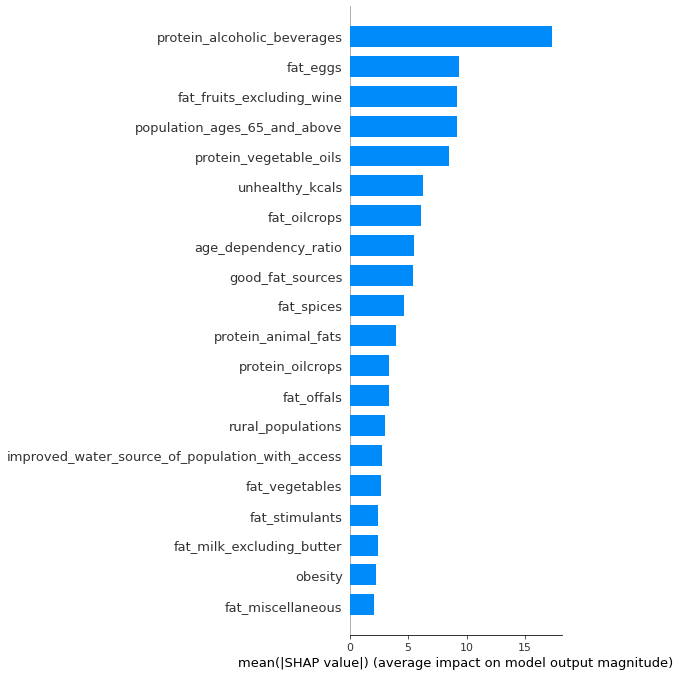

In [35]:
shap_values = shap.TreeExplainer(model).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

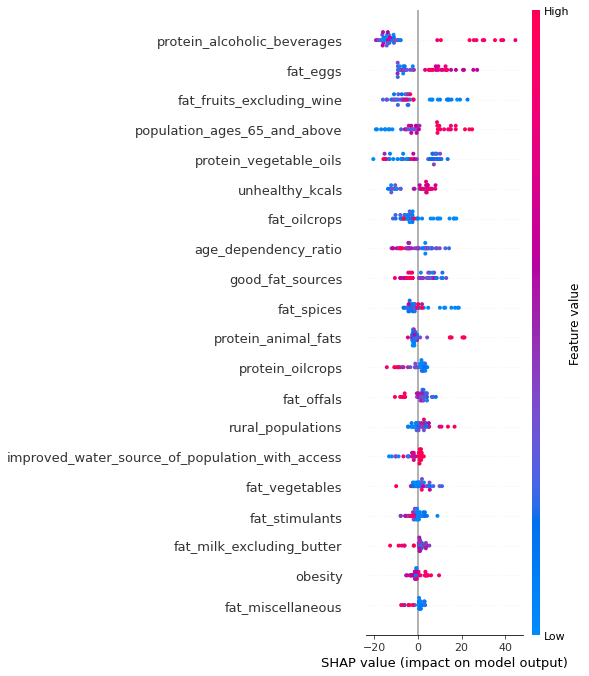

In [36]:
shap.summary_plot(shap_values, x_train)